<div style='background-color:#1155CC'>
<br>
<p style='text-align:center; font-size:200%; color:white; font-weight:bold'>Twitter Sentiment Analysis</p><br>
<p style='text-align:center; font-size:150%; color:white; font-weight:500'>Andrean Yonathan - Universitas Diponegoro</p>
<br>
</div>

# Import Library

In [ ]:
import pandas as pd
import numpy as np
import keras

# library for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# library for text pre-processing
import regex as re
import nltk
nltk.download('stopwords')
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import *
!pip install emot
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO

# library for features extraction
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# library for build and evaluate model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Input, Embedding

# library for save model
import pickle

# mount drive
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 61 kB 20 kB/s 
Mounted at /content/drive


# Load Dataset

The data obtained from Kaggle open dataset (https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/SIB/Natural Language Processing/Deep Learning/Twitter Sentiment Analysist/Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# Data Understanding

## check imbalance dataset

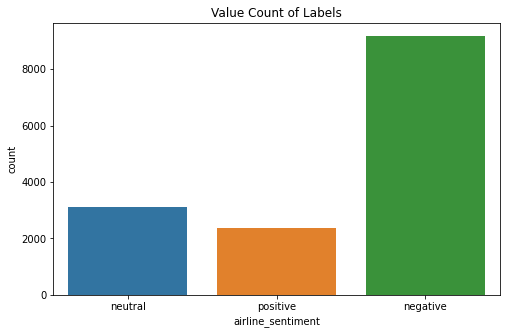



Number of neutral label: 3099
Number of positive label: 2363
Number of negative label: 9178


In [ ]:
plt.figure(figsize = (8,5))
sns.countplot(data = df, x = 'airline_sentiment')
plt.title('Value Count of Labels')
plt.show()

print('\n')
print('Number of neutral label:', len(df[df['airline_sentiment'] == 'neutral']))
print('Number of positive label:', len(df[df['airline_sentiment'] == 'positive']))
print('Number of negative label:', len(df[df['airline_sentiment'] == 'negative']))

## check missing values

In [ ]:
df.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

# Data Understanding Report

* Data is imbalance because the ratio of the number of negative labels is very far from the positive and neutral labels
* Data has missing values but in this case, we only use `airline_sentiment` and `text` columns. So, we will create new dataframe that contains `airline_sentiment` and `text` columns.

# Text Pre-processing

What will be done in this process is:
1. Drop unnecesarry column(s).
2. Lower casing.
3. Label encoding for target feature.
4. Token masking.
5. Text cleaning, such as remove unnecessary character, remove punctuation, etc.
6. Text normalization.
7. Stopwords removal.

## Drop unnecessarry columns

In [ ]:
df = df[['text', 'airline_sentiment']]
df.rename(columns = {'airline_sentiment' : 'label'}, inplace = True)
df.head()

,text,label
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


# Text Processing

## Lower Case

In [ ]:
lower = []
for i in df['text']:
    i = i.lower()
    lower.append(i)
df['text'] = lower

## Label Encoding

In [ ]:
def labelEncoding(label):
    le = LabelEncoder()
    le.fit(label)
    label = le.transform(label)
    label_name = dict(zip(le.classes_, le.transform(le.classes_)))
    print(label_name)
    return label

df['label'] = labelEncoding(df['label'])

{'negative': 0, 'neutral': 1, 'positive': 2}


## Emoji and Emoticon Normalization

In [ ]:
def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, '_'.join(UNICODE_EMOJI[emot].replace(',','').replace(':','').split()))
    return text

def convert_emoticons(text):
    for emot in EMOTICONS_EMO:
        text = text.replace(emot, '_'.join(EMOTICONS_EMO[emot].replace(",","").split()))
    return text

## Text Normalization

In [ ]:
cons = pd.read_csv('/content/drive/MyDrive/SIB/Natural Language Processing/Deep Learning/Twitter Sentiment Analysist/contraction.csv')
cons_dict = dict(zip(cons['constrain'], cons['meaning']))

def text_norm(tx):
    tx = tx.replace(';','')
    for i in tx.split():
        if i in cons_dict.keys():
            tx = tx.replace(i, cons_dict[i])
    return tx

## Token Masking

In [ ]:
def token_masking(tx):
     tx = re.sub(r'(?:\@)\S+', 'username', tx) # masking @ to username
     tx = re.sub(r'(?:\http|www.)\S+', 'URL', tx) # masking https to url
     tx = re.sub(r'(?:#[a-z])\S+', '', tx)
     return tx

## Text Cleaning

In [ ]:
def text_cleaning(tx):
    tx = re.sub(r'[^\x00-\x7f]', r'', tx) # remove hex character
    tx = tx.replace("\n", ' ') # remove \n
    tx = tx.replace("_", ' ') # replace underscore on emoticon
    tx = re.sub(r'[\d]', '', tx) # remove number
    tx = re.sub(r'[^\w\s]', '', tx) # remove punctuation
    rpt_regex = re.compile(r"(.)\1{1,}", re.IGNORECASE) # regex to normalized repeated character like hiii
    tx = rpt_regex.sub(r"\1\1", tx) # remove repeated word
    tx = tx.strip() # trim head and tail
    tx = re.sub(' +', ' ', tx) # remove multiple space
    return tx

## Stopwords Removal

In [ ]:
stop_words = stopwords.words('english')

def stopwords_removal(tx):
    word_list = tx.split()
    tx = ' '.join(word for word in word_list if word not in stop_words)
    return tx

## Stemming

In [ ]:
stemmer = SnowballStemmer('english')

def stemming(tx):
    temp = []
    for i in tx.split():
        i = stemmer.stem(i)
        temp.append(i)
    tx = ' '.join(temp)
    return tx

In [ ]:
lemmatizer = WordNetLemmatizer()

def lemma(tx):
    temp = []
    for i in tx.split():
        i = lemmatizer.lemmatize(i, pos = 'a')
        temp.append(i)
    tx = ' '.join(temp)
    return tx

## Function for Text Processing

In [ ]:
# function for text processing
def text_processing(text):
    text = text.lower()
    text = convert_emojis(text)
    text = convert_emoticons(text)
    text = text_norm(text)
    text = token_masking(text)
    text = text_cleaning(text)
    text = stopwords_removal(text)
    # text = lemma(text)
    return text


In [ ]:
nltk.download('wordnet')
text_list = []
for text in list(df['text']):
    text = text_processing(text)
    text_list.append(text)
df['text'] = text_list

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Features Extraction

## Tokenization

In [ ]:
df_features = df['text']
df_target = df['label']
df_target = np.array(df_target)
# new = feature_extraction(df_features, df_target).head(

In [ ]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(df_features)

X = tokenizer.texts_to_sequences(df_features)

## Padding

In [ ]:
X = pad_sequences(X, maxlen = 150)

## Split Dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, df_target, test_size = 0.2)

# Modelling

In [ ]:
# create architecture
from keras.layers import Dropout
vocab_size = len(tokenizer.word_index)+1
embedding_vector_length = 32
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_vector_length, input_length = 150))
model2.add(LSTM(128, activation = 'tanh', return_sequences = 'True', dropout = 0.2))
# model2.add(Dropout(0.2))
model2.add(LSTM(56, activation = 'tanh', dropout = 0.2))
# model2.add(Dropout(0.2))
model2.add(Dense(1, activation = 'sigmoid'))
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print((model2.summary()))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 32)           369344    
                                                                 
 lstm (LSTM)                 (None, 150, 128)          82432     
                                                                 
 lstm_1 (LSTM)               (None, 56)                41440     
                                                                 
 dense (Dense)               (None, 1)                 57        
                                                                 
Total params: 493,273
Trainable params: 493,273
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# training model
model2.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 20)

Epoch 1/20
366/366 [==============================] - 41s 91ms/step - loss: 1.6681 - accuracy: 0.3936 - val_loss: 0.6921 - val_accuracy: 0.2196
Epoch 2/20
366/366 [==============================] - 32s 87ms/step - loss: 0.6920 - accuracy: 0.2219 - val_loss: 0.6905 - val_accuracy: 0.2196
Epoch 3/20
366/366 [==============================] - 32s 88ms/step - loss: 0.6921 - accuracy: 0.2328 - val_loss: 0.6912 - val_accuracy: 0.2196
Epoch 4/20
366/366 [==============================] - 32s 87ms/step - loss: 0.6931 - accuracy: 0.2456 - val_loss: 0.6929 - val_accuracy: 0.2196
Epoch 5/20
366/366 [==============================] - 32s 87ms/step - loss: 0.6919 - accuracy: 0.2579 - val_loss: 0.6942 - val_accuracy: 0.6212
Epoch 6/20
366/366 [==============================] - 32s 87ms/step - loss: 0.6931 - accuracy: 0.2354 - val_loss: 0.6904 - val_accuracy: 0.2196
Epoch 7/20
366/366 [==============================] - 32s 87ms/step - loss: 0.6933 - accuracy: 0.2730 - val_loss: 0.6912 - val_accuracy:

In [ ]:
# predict
y_pred = model2.predict(X_test)

# Evaluation

In [ ]:
print('Accuracy model: {:.2%}'.format(accuracy_score(y_test, np.argmax(y_pred, axis = 1))), '\n')
print('Classification report\n', classification_report(y_test, np.argmax(y_pred, axis = 1)))

Accuracy model: 62.12% 

Classification report
               precision    recall  f1-score   support

           0       0.62      1.00      0.77      1819
           1       0.00      0.00      0.00       643
           2       0.00      0.00      0.00       466

    accuracy                           0.62      2928
   macro avg       0.21      0.33      0.26      2928
weighted avg       0.39      0.62      0.48      2928



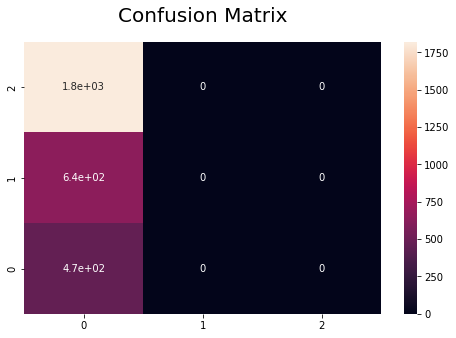

In [ ]:
# confusion matrix
labels = np.unique(np.array(df['label']))
labels_inv = np.flip(labels)
ax = plt.figure(figsize = (8,5))
ax = plt.subplot()
cm = confusion_matrix(y_test, (np.argmax((y_pred), axis = 1)))
sns.heatmap(cm, annot = True)
plt.title('Confusion Matrix', fontsize = 20, pad = 20)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels_inv)
plt.show()